In [1]:
import numpy as np
import Robot
import matplotlib.pyplot as plt
import MyRobotMath as math
from MyRobotMath import SE3, quintic_time_scaling

scara = Robot.SCARA(2,1,1,0)
se3 = SE3()
M = scara.zero
S = scara.S_tw
B = scara.B_tw
N = len(scara.joints)

In [2]:
desired = [0.6,0.4,1.2,0,0,-77] # 목표 자세의 (x,y,z,roll,pitch,yaw)
T_d = se3.pose_to_SE3(desired) # 목표 자세의 Tranformation Matrix
threshold = 1e-6 # 오차 범위
count = 0

init = [0,0,0,0]

while True:

    matexps_b = []
    matexps_s = []

    count += 1 # 연산 횟수 증가

    for i in range(N):
        matexps_b.append(se3.matexp(scara.joints[i].type,init[i],B[i])) # Body Axis 기준 각 축의 Matrix Exponential
        matexps_s.append(se3.matexp(scara.joints[i].type,init[i],S[i])) # Space Axis 기준 각 축의 Matrix Exponential

    T_sb = se3.matFK(M,matexps_b) # Forward Kinematics 적용 변환행렬
    estimated = []
    for i in range(3):
        estimated.append(T_sb[i,3].item()) # 현재 x, y, z
    
    eulerAngles = se3.CurrenntAngles(T_sb)
    for eulerAngle in eulerAngles:
        estimated.append(eulerAngle) # Euler 각도 추정값

    pos_err = np.array(desired[:3]) - np.array(estimated[:3]) # x, y, z 오차

    T_bd = np.dot(np.linalg.inv(T_sb),T_d) # Relative Trasformation Matrix
    J_b = se3.body_jacobian(M,matexps_b,matexps_s,S) # Body Jacobian
    J_pseudo = se3.j_inv(J_b) # Jacobian의 역행렬 (또는 의사역행렬)
    V_bd = se3.relativetwist(T_bd) # Ralative Twist, 각도 오차

    theta = math.deg2rad(init,scara.joints)
    thetak = theta.reshape(N,1) + J_pseudo @ V_bd.reshape(6,1) # Newton Raphson Method
    thetak = math.rad2deg(thetak,scara.joints) # radian to degree
    init = math.theta_normalize(thetak,scara.joints) # 각도 정규화 (-180~180)

    if np.all(np.abs(pos_err) < threshold): # 오차가 임계값 이내면 break
        print(estimated)
        print(f"연산 횟수 : {count}, Joint Value : {init}")
        break


[0.599999994606975, 0.39999998459627073, 1.2, -0.0, 0.0, -76.99999999999996]
연산 횟수 : 11, Joint Value : [-35.175640259234, 137.73141557042754, -0.8, -179.55577531119357]


In [3]:
end = init

matexps = []

for i in range(N):
    matexps.append(se3.matexp(scara.joints[i].type,end[i],B[i])) # Body Axis 기준 각 축의 Matrix Exponential

In [4]:
for matexp in matexps:
    print(matexp)

[[ 0.8173899   0.57608485  0.         -0.3652202 ]
 [-0.57608485  0.8173899   0.         -1.1521697 ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
[[-0.74       -0.67260687  0.         -1.74      ]
 [ 0.67260687 -0.74        0.          0.67260687]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
[[ 1.   0.   0.   0. ]
 [ 0.   1.   0.   0. ]
 [ 0.   0.   1.  -0.8]
 [ 0.   0.   0.   1. ]]
[[-0.99996994  0.00775311  0.          0.        ]
 [-0.00775311 -0.99996994  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


In [5]:
poses = [M]
T = M
for i in range(len(matexps)):
    T = T @ matexps[i]
    poses.append(T)

for pose in poses:
    print(pose)

[[1 0 0 2]
 [0 1 0 0]
 [0 0 1 2]
 [0 0 0 1]]
[[ 0.8173899   0.57608485  0.          1.6347798 ]
 [-0.57608485  0.8173899   0.         -1.1521697 ]
 [ 0.          0.          1.          2.        ]
 [ 0.          0.          0.          1.        ]]
[[-0.2173899  -0.97608485  0.          0.6       ]
 [ 0.97608485 -0.2173899   0.          0.4       ]
 [ 0.          0.          1.          2.        ]
 [ 0.          0.          0.          1.        ]]
[[-0.2173899  -0.97608485  0.          0.6       ]
 [ 0.97608485 -0.2173899   0.          0.4       ]
 [ 0.          0.          1.          1.2       ]
 [ 0.          0.          0.          1.        ]]
[[ 0.22495105  0.97437006  0.          0.6       ]
 [-0.97437006  0.22495105  0.          0.4       ]
 [ 0.          0.          1.          1.2       ]
 [ 0.          0.          0.          1.        ]]


In [6]:
def forward_kinematics_all_body(joint_values):
    T = scara.zero.copy()
    poses = [T.copy()]
    for joint, val, tw in zip(scara.joints, joint_values, scara.B_tw):
        T = T @ se3.matexp(joint.type, val, tw)
        poses.append(T.copy())
    return poses

In [7]:
poses = forward_kinematics_all_body(end)

In [8]:
for i, pose in enumerate(poses):
    print(f"T{i}:\n", pose)

T0:
 [[1 0 0 2]
 [0 1 0 0]
 [0 0 1 2]
 [0 0 0 1]]
T1:
 [[ 0.8173899   0.57608485  0.          1.6347798 ]
 [-0.57608485  0.8173899   0.         -1.1521697 ]
 [ 0.          0.          1.          2.        ]
 [ 0.          0.          0.          1.        ]]
T2:
 [[-0.2173899  -0.97608485  0.          0.6       ]
 [ 0.97608485 -0.2173899   0.          0.4       ]
 [ 0.          0.          1.          2.        ]
 [ 0.          0.          0.          1.        ]]
T3:
 [[-0.2173899  -0.97608485  0.          0.6       ]
 [ 0.97608485 -0.2173899   0.          0.4       ]
 [ 0.          0.          1.          1.2       ]
 [ 0.          0.          0.          1.        ]]
T4:
 [[ 0.22495105  0.97437006  0.          0.6       ]
 [-0.97437006  0.22495105  0.          0.4       ]
 [ 0.          0.          1.          1.2       ]
 [ 0.          0.          0.          1.        ]]


In [9]:
theta_start = np.array([135,45,0,0.2])
theta_end = np.array(init)
print(theta_start,theta_end)

[135.   45.    0.    0.2] [ -35.17564026  137.73141557   -0.8        -179.55577531]


In [10]:
T = 4.0
N = 200

trajectory = []
velocity = []
accelation = []

for i in range(N):
    t = i / N * T
    s, s_dot, s_ddot = quintic_time_scaling(t, T)
    theta_desired = theta_start + s*(theta_end-theta_start)
    theta_dot = s_dot*(theta_end-theta_start)
    theta_ddot = s_ddot*(theta_end-theta_start)
    trajectory.append(theta_desired)
    velocity.append(theta_dot)
    accelation.append(theta_ddot)

trajectory = np.array(trajectory).T  # shape = (4, N)
velocity = np.array(velocity).T
accelation = np.array(accelation).T

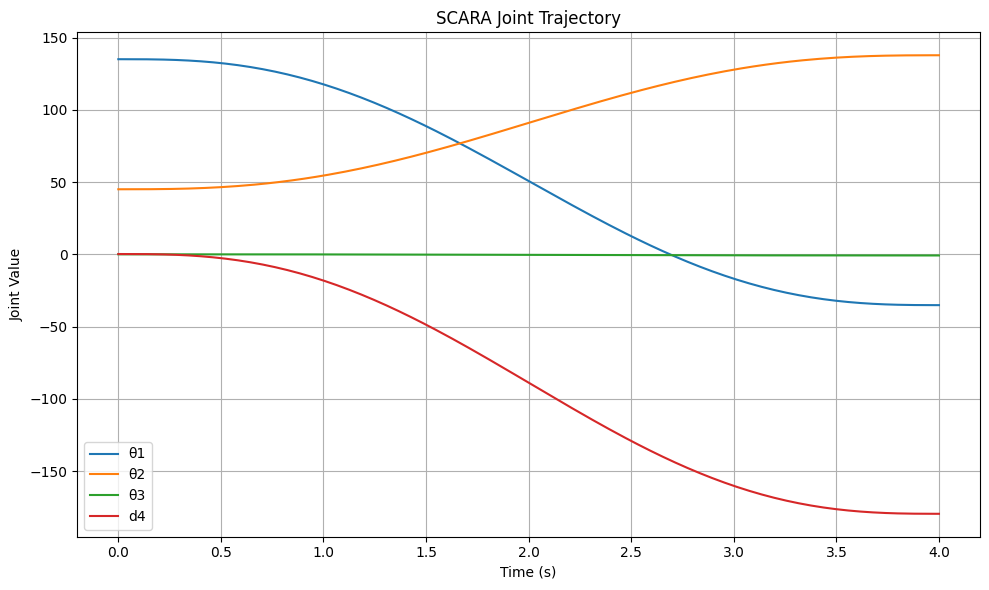

In [11]:
plt.figure(figsize=(10, 6))
for i, joint in enumerate(["θ1", "θ2", "θ3", "d4"]):
    plt.plot(np.linspace(0, T, N), trajectory[i], label=joint)

plt.xlabel("Time (s)")
plt.ylabel("Joint Value")
plt.title("SCARA Joint Trajectory")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

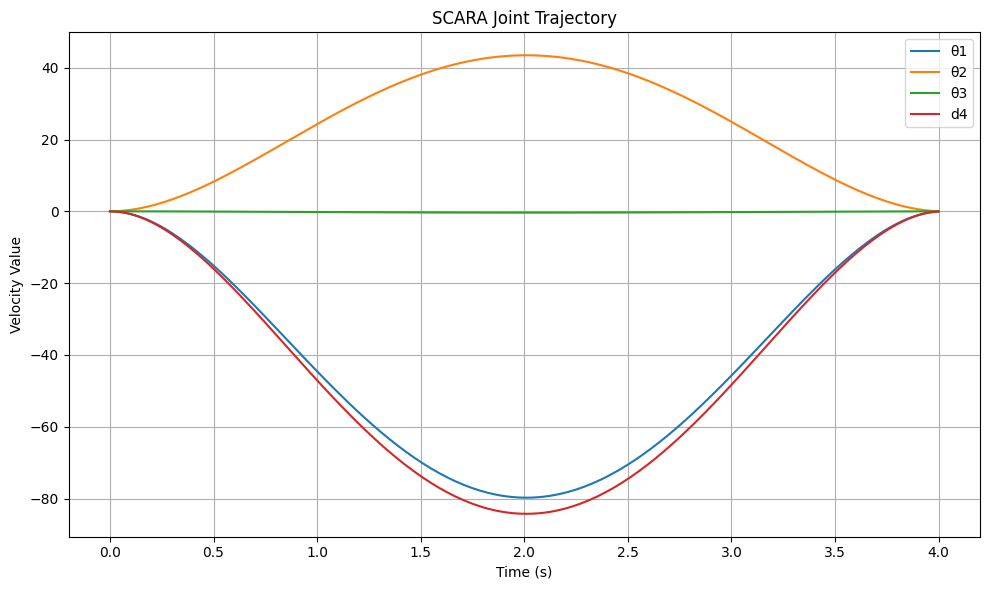

In [12]:
plt.figure(figsize=(10, 6))
for i, joint in enumerate(["θ1", "θ2", "θ3", "d4"]):
    plt.plot(np.linspace(0, T, N), velocity[i], label=joint)

plt.xlabel("Time (s)")
plt.ylabel("Velocity Value")
plt.title("SCARA Joint Trajectory")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
print(np.zeros(3))

[0. 0. 0.]
